# ECE 763 Project 01: Face Detection
## faceScrub dataset

In [1]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

### Methods

In [20]:
# Create dataset dictionaries
def buildDataset(actors_list):
  img_set = [] # empty list
  for actor in tqdm(actors_list, total=len(actors_list) ,desc='Loading dataset'):
    img0 = {} # empty dictionary
    img1 = {} # empty dictionary
    try:
      # create dictionary and add it to the list
      img0['file'] = actor['0']
      img0['class'] = 0
      img0['image'] = Image.open(actor['0'])
      img_set.append(img0)
      img1['file'] = actor['1']
      img1['class'] = 1
      img1['image'] = Image.open(actor['1'])
      img_set.append(img1)
    except:
      print(actor['name'] + " couldn't be found!")
  return img_set


# Reshape vector to RGB image
def convertToImg(x, img_size):
    return ((x * 255.0).reshape(img_size[0],img_size[1],-1)).astype(int)


# Create matrix of data of size (dimension, samples)
def createVector(set, label):
    X_subset = [ face for face in set if face['class']==label ]
    x_len = set[0]['image'].shape[0]
    X = np.empty( (x_len,len(X_subset)) )
    for i,face in enumerate(X_subset):
        X[:,i] = face['image']
    return X


# Compute the log-probability of a Single Multivariable Guassian distribution
def pLogSMG(data, meanVector, covVector):
    dim = len(meanVector.ravel())
    log2pi = -dim/2 * np.log(2*math.pi)
    logCovVector = -1/2 * np.sum(np.log(covVector),where=(covVector>0))
    logMeanVectorData = -1/2 \
    * np.sum( np.power(data - meanVector,2) / covVector,axis=1 )
    logProb = log2pi + logCovVector + logMeanVectorData
    return logProb


# Inference using Single Multivariate Gaussian model
def inferSMG( X, label, mu, sigma, threshold):
    # Probability given Non-face P(x|w=0)
    logProb_0 = pLogSMG(X.T, mu[0], sigma[0].diagonal())
    prob_0 = np.exp(logProb_0)

    # Probability given Face P(x|w=1)
    logProb_1 = pLogSMG(X.T, mu[1], sigma[1].diagonal())
    prob_1 = np.exp(logProb_1)

    # Creates lables vector and normalize probability
    num_data = X.shape[1]
    lbls = np.empty(num_data)
    if label==1:
      lbls = np.ones(num_data)
      # Normalize probability a.k.a inference P(w=1|x)
      # prob = prob_1 / (prob_0 + prob_1)
    if label==0:
      lbls = np.zeros(num_data)
    # Normalize probability a.k.a inference P(w=0|x)
    prob = prob_0 / (prob_0 + prob_1)

    num_true = sum( (prob >= threshold) == lbls)
    num_false = num_data - num_true

    return  num_true, num_false


Load datasets into memmory

In [3]:
test_actors = []
train_actors = []

test_file = './data/test/test.txt'
train_file = './data/training/training.txt'

# Read test data
with open(test_file, newline='') as actors:
    actors_reader = csv.DictReader(actors, delimiter='\t')
    for actor in actors_reader:
        test_actors.append(actor)

# Read training data
with open(train_file, newline='') as actors:
    actors_reader = csv.DictReader(actors, delimiter='\t')
    for actor in actors_reader:
        train_actors.append(actor)

# Build datasets
test_set = buildDataset(test_actors)
train_set = buildDataset(train_actors)

Loading dataset: 100%|██████████| 1000/1000 [00:00<00:00, 12150.85it/s]


Concatenate RGB values and normalize data

In [4]:
# Convert images to np array
for face in test_set:
    face['image'] = np.asfarray(face['image']).flatten() / 255.0
for face in train_set:
    face['image'] = np.asfarray(face['image']).flatten() / 255.0

# Inspect data
print('Sample from test set: ')
print(test_set[0]['image'])
print('shape: ' , test_set[0]['image'].shape)
print('Sample from training set: ')
print(train_set[0]['image'])
print('shape: ' , test_set[0]['image'].shape)

Sample from test set: 
[0.4        0.42745098 0.63137255 ... 0.24313725 0.28235294 0.41960784]
shape:  (1200,)
Sample from training set: 
[0.41568627 0.21960784 0.17647059 ... 0.4        0.25098039 0.2       ]
shape:  (1200,)


Crete training-class subsets matrix

In [5]:
X0_train = createVector(train_set,0)
X1_train = createVector(train_set,1)

# Sanity check
print('X0_train shape: ' , X0_train.shape)
print('X1_train shape: ' , X1_train.shape)

X0_train shape:  (1200, 1000)
X1_train shape:  (1200, 1000)


Compute sample mean vector and sample covariance matrix

In [34]:
# Mean
mu0 = X0_train.mean(axis=1)
mu1 = X1_train.mean(axis=1)

# Covariance
sigma0 = np.cov(X0_train, bias=True)
sigma1 = np.cov(X1_train, bias=True)

# def fitSMG(data):
#     numData = data.shape[0]
#     meanVector = np.sum(data,axis=0)/numData
#     covVector = np.zeros([1,data[0].size])
#     for i in range(0,numData):
#         dataVector = data[i]
#         covVector += np.power(dataVector-meanVector,2)
#     covVector = covVector/numData
#     return meanVector, covVector

# m0 , c0 = fitSMG(X1_train.T)


# Check Results
# print(m0)
print('X0 mean = ', mu0)
print('X1 mean = ', mu1)
# print(c0)
print('X0 cov  = ', sigma0.diagonal())
print('X1 cov  = ', sigma1.diagonal())

X0 mean =  [0.43417255 0.38098431 0.35311373 ... 0.42512549 0.37319216 0.34605882]
X1 mean =  [0.35471373 0.28687451 0.24862745 ... 0.4491451  0.39176471 0.36153725]
X0 cov  =  [0.10208597 0.08856834 0.08769996 ... 0.10229809 0.08649979 0.08616601]
X1 cov  =  [0.06755294 0.06169248 0.06020254 ... 0.09499548 0.08762541 0.08671743]


Visualize the estimated mean and covariance matrix for face and non-face respectively

Text(0.5, 1.0, '$\\Sigma_1^{diag}$')

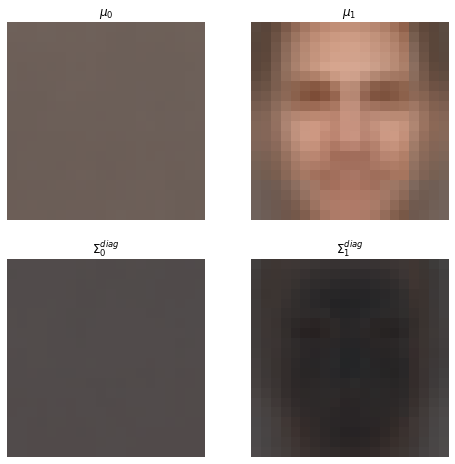

In [10]:
mu0_img = convertToImg(mu0, (20,20))
mu1_img = convertToImg(mu1, (20,20))

sigma0_img = convertToImg(np.sqrt(sigma0.diagonal()), (20,20))
sigma1_img = convertToImg(np.sqrt(sigma1.diagonal()), (20,20))

# Plot code
fig, axes = plt.subplots(2,2, figsize=(8,8))
[axi.axis('off') for axi in axes.flat] # hide axis

axes[0,1].imshow(mu1_img)
axes[0,1].set_title(r'$\mu_1$')
axes[0,0].imshow(mu0_img)
axes[0,0].set_title(r'$\mu_0$')
axes[1,0].imshow(sigma0_img)
axes[1,0].set_title(r'$\Sigma_0^{diag}$')
axes[1,1].imshow(sigma1_img)
axes[1,1].set_title(r'$\Sigma_1^{diag}$')

Evaluate the learned model on the testing images using 0.5 as threshold for the posterior. Compute False Positive Rate (FPR), False Negative Rate (FNR) and the missclasification rate (MR).

In [39]:
# Create test data matrixes
X0_test = createVector(test_set,0)
X1_test = createVector(test_set,1)

# threshold = 0.5 # detection threshold
# TP, FN = inferSMG( X0_test, 1, (mu0,mu1), (sigma0,sigma1), threshold)
# TN, FP = inferSMG( X1_test, 0, (mu0,mu1), (sigma0,sigma1), threshold)

def logProbSMG(data, meanVector, covVector):
    dim = len(meanVector.ravel())
    log2pi = -dim/2*np.log(2*math.pi)
    logCovVector = -1/2*np.sum(np.log(covVector),where=(covVector>0))
    logMeanVectorData = -1/2*np.sum(np.power(data-meanVector,2)/covVector,axis=1)
    logProb = log2pi+logCovVector+logMeanVectorData
    return logProb

def predictSMG(dataVector,label,mean,covariance,threshold):
    numData = dataVector.shape[0]
    numClass = len(mean)
    logProb = np.zeros([numClass,numData]) # Rows = Classes, Columns = Data Points
    # Calculing logprobabilities oves all Classes and Data points
    for i in range(0,numClass):
        logProb[i,:] = logProbSMG(dataVector, mean[i], covariance[i])   
    prob = np.exp(logProb)    
    normProb = prob[0,:]/(prob[0,:]+prob[1,:])
    numTrue = sum((normProb>=threshold)==label)
    numFalse = numData - numTrue
    return numTrue,numFalse


threshold = 0.5 # detection threshold
mu = np.array([mu1,mu0])
sigma = np.array([sigma1.diagonal(), sigma0.diagonal()])
TP, FN = predictSMG( X0_test.T, np.ones(X0_test.shape[1]), mu, sigma, threshold)
TN, FP = predictSMG( X1_test.T, np.zeros(X1_test.shape[1]), mu, sigma, threshold)

# Compute rates
FPR = FP / (FP+TN)
FNR = FN / (TP+FN)
MR = (FP + FN) / (X0_test.shape[1] + X1_test.shape[1])

# Print results
print("False Positive Rate   : ",round(FPR,3))
print("False Negative Rate   : ",round(FNR,3))
print("Misclassification Rate: ",round(MR,3))

False Positive Rate   :  0.81
False Negative Rate   :  0.74
Misclassification Rate:  0.775


ROC curve

Text(0.5, 1.0, 'ROC Curve Simple Gaussian Model')

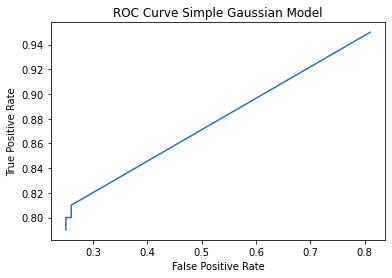

In [40]:
plt.figure()
lenROC = 1000
pltFPR=np.zeros(lenROC)
pltTPR=np.zeros(lenROC)
for i in range(0,lenROC):
    threshold = i/(lenROC-1)
    # TP, FN = inferSMG( X0_test, 1, (mu0,mu1), (sigma0,sigma1), threshold)
    # TN, FP = inferSMG( X1_test, 0, (mu0,mu1), (sigma0,sigma1), threshold)
    nonfaceTrue,nonfaceFalse = predictSMG( X0_test.T, np.zeros(X0_test.shape[1]), mu, sigma, threshold)
    faceTrue,faceFalse = predictSMG( X1_test.T, np.ones(X1_test.shape[1]), mu, sigma, threshold)
    pltFPR[i] = nonfaceFalse/(nonfaceFalse+nonfaceTrue)
    pltTPR[i] = 1 - faceFalse/(faceFalse+faceTrue)
plt.plot(pltFPR,pltTPR)
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate") 
plt.title("ROC Curve Simple Gaussian Model")
